In [1]:
from sklearn.preprocessing import StandardScaler
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
import torch.backends.cudnn as cudnn
import matplotlib.pyplot as plt
import torch.utils.data as Data
import matplotlib as mpl
import scipy.io as sio
import numpy as np
import argparse
import time

import torch
import torch.nn as nn
from torch import optim
import torch.utils.data as Data
import torch.nn.functional as F
from torchsummary import summary
import torch.backends.cudnn as cudnn
from sklearn.metrics import confusion_matrix


from data_prepare import mirror_hsi
from Utils import ActivationOutputData, safe_norm
from caps_vit import CapsViT, Margin_Recon_Loss
from data_prepare import choose_train_and_test_number
from Utils import output_metric, plot_confusion_matrix
from Utils import train_epoch, test_epoch, valid_epoch
from data_prepare import choose_train_and_test_proportion
from Utils import list_to_colormap, classification_map, print_args
from data_prepare import train_and_test_data, train_and_test_label


%matplotlib inline

In [2]:
parser = argparse.ArgumentParser("Caps-Transformer")
parser.add_argument('--dataset', choices=['Indian', 'Pavia', 'KSC'], default='KSC', help='dataset to use')
parser.add_argument('--flag_test', choices=['test', 'train'], default='train', help='testing mark')
parser.add_argument('--mode', choices=['ViT', 'CAF'], default='CAF', help='mode choice')
parser.add_argument('--gpu_id', default='0', help='GPU id')
parser.add_argument('--seed', type=int, default=0, help='number of seed')
parser.add_argument('--batch_size', type=int, default=30, help='number of batch size')
parser.add_argument('--patch_size', type=int, default=7, help='size of patches')
parser.add_argument('--epoches', type=int, default=200, help='epoch number')
parser.add_argument('--learning_rate', type=float, default=5e-4, help='learning rate')
parser.add_argument('--gamma', type=float, default=0.99, help='gamma')
parser.add_argument('--weight_decay', type=float, default=0.001, help='weight_decay')
parser.add_argument('--train_number', type=int, default=1, help='num_train_per_class')
parser.add_argument('--train_proportion', type=float, default=0.1, help='num_train_per_class')
args = parser.parse_args(args=[])

In [3]:
# 设置torch.random和torch.cuda.random随机种子，使模型的各种参数初始化以及DataLoader在生成随机小批量时在每次实验过程中
# 均保持一致，以保证每次运行的实验结果尽量保持相同

torch.manual_seed(args.seed)
torch.cuda.manual_seed(args.seed)
cudnn.deterministic = True
cudnn.benchmark = False

In [4]:
# prepare data
if args.dataset == 'Indian':
    data = sio.loadmat('./dataset/Indian_pines_corrected.mat')['indian_pines_corrected']
    label = sio.loadmat('./dataset/Indian_pines_gt.mat')['indian_pines_gt']
elif args.dataset == 'Pavia':
    data = sio.loadmat('./dataset/PaviaU.mat')['paviaU']
    label = sio.loadmat('./dataset/PaviaU_gt.mat')['paviaU_gt']
elif args.dataset == 'KSC':
    data = sio.loadmat('./dataset/KSC.mat')['KSC']
    label = sio.loadmat('./dataset/KSC_gt.mat')['KSC_gt']
else:
    raise ValueError("Unknown dataset")
    
num_classes = np.max(label)
print('The class numbers of the HSI data is:', num_classes)

The class numbers of the HSI data is: 13


In [5]:
shapeor = data.shape
data = data.reshape(np.prod(data.shape[:2]), np.prod(data.shape[2:]))

std_scaler = StandardScaler()
std_data = std_scaler.fit_transform(data)
data = std_data.reshape(shapeor)

In [6]:
total_pos_train, total_pos_test, total_pos_true, number_train, number_test, number_true = \
choose_train_and_test_number(label, args.train_number, seed=args.seed)

# data size
height, width, band = data.shape
print("height={0}, width={1}, band={2}".format(height, width, band))

height=512, width=614, band=176


In [7]:
mirror_data = mirror_hsi(height, width, band, data, patch_size=args.patch_size)

x_train, x_test, x_true = train_and_test_data(mirror_data, band, total_pos_train, total_pos_test, 
                                              total_pos_true, patch_size=args.patch_size)

**************************************************
patch_size is : 7
mirror_data shape : [518, 620, 176]
**************************************************
x_train shape = (13, 7, 7, 176), type = float64
x_test  shape = (5198, 7, 7, 176), type = float64
x_true  shape = (5211, 7, 7, 176), type = float64
**************************************************


In [8]:
y_train, y_test, y_true = train_and_test_label(number_train, number_test, number_true, num_classes)

# load data
x_train = torch.from_numpy(x_train.transpose(0, 3, 1, 2)).type(torch.FloatTensor)  # (13, 176, 7, 7)
print(x_train.shape)
y_train = torch.from_numpy(y_train).type(torch.LongTensor)  # (13,)
Train_Label = Data.TensorDataset(x_train, y_train)

x_test = torch.from_numpy(x_test.transpose(0, 3, 1, 2)).type(torch.FloatTensor)  # (5198, 176, 7, 7)
print(x_test.shape)
y_test = torch.from_numpy(y_test).type(torch.LongTensor)  # (5198,)
Test_Label = Data.TensorDataset(x_test, y_test)

x_true = torch.from_numpy(x_true.transpose(0, 3, 1, 2)).type(torch.FloatTensor)  # (5211, 176, 7, 7)
print(x_true.shape)
y_true = torch.from_numpy(y_true).type(torch.LongTensor)
True_Label = Data.TensorDataset(x_true, y_true)

train_loader = Data.DataLoader(Train_Label, batch_size=args.batch_size, shuffle=True)
test_loader = Data.DataLoader(Test_Label, batch_size=args.batch_size, shuffle=True)
true_loader = Data.DataLoader(True_Label, batch_size=100, shuffle=False)

y_train: shape = (13,), type = int64
y_test: shape = (5198,), type = int64
y_true: shape = (5211,), type = int64
**************************************************
torch.Size([13, 176, 7, 7])
torch.Size([5198, 176, 7, 7])
torch.Size([5211, 176, 7, 7])


In [9]:
model = CapsViT(band, args.patch_size, preliminary_layer_channels=96, mode=args.mode, caps2_caps=num_classes)

model = model.cuda()
# criterion
criterion = Margin_Recon_Loss()
# optimizer
optimizer = optim.Adam(model.parameters(), lr=args.learning_rate, weight_decay=args.weight_decay)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=args.gamma)
# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=args.epoches//10, gamma=args.gamma)

In [10]:
print('start training')
# train model
model.train()
tic = time.time()
for epoch in range(args.epoches):
    # 计算的是移动平均准确率
    train_acc, train_obj, tar_train, pre_train = train_epoch(model, train_loader, criterion, optimizer)
    OA_trian, AA_mean_train, Kappa_train, AA_train = output_metric(tar_train, pre_train)
    print("Epoch: {:03d} train_loss: {:.4f} train_acc: {:.4f}".format(epoch+1, train_obj, train_acc))
    scheduler.step()

toc = time.time()
print("Running Time: {:.2f}".format(toc-tic))
print("**************************************************")

start training
Epoch: 001 train_loss: 0.8098 train_acc: 7.6923
Epoch: 002 train_loss: 0.7769 train_acc: 23.0769
Epoch: 003 train_loss: 0.7070 train_acc: 15.3846
Epoch: 004 train_loss: 0.6100 train_acc: 30.7692
Epoch: 005 train_loss: 0.5498 train_acc: 15.3846
Epoch: 006 train_loss: 0.5657 train_acc: 23.0769
Epoch: 007 train_loss: 0.5932 train_acc: 61.5385
Epoch: 008 train_loss: 0.5830 train_acc: 30.7692
Epoch: 009 train_loss: 0.5574 train_acc: 15.3846
Epoch: 010 train_loss: 0.5391 train_acc: 30.7692
Epoch: 011 train_loss: 0.5447 train_acc: 15.3846
Epoch: 012 train_loss: 0.5527 train_acc: 46.1538
Epoch: 013 train_loss: 0.5508 train_acc: 84.6154
Epoch: 014 train_loss: 0.5399 train_acc: 61.5385
Epoch: 015 train_loss: 0.5267 train_acc: 46.1538
Epoch: 016 train_loss: 0.5171 train_acc: 38.4615
Epoch: 017 train_loss: 0.5156 train_acc: 46.1538
Epoch: 018 train_loss: 0.5128 train_acc: 61.5385
Epoch: 019 train_loss: 0.5070 train_acc: 61.5385
Epoch: 020 train_loss: 0.4973 train_acc: 61.5385
Epoch:

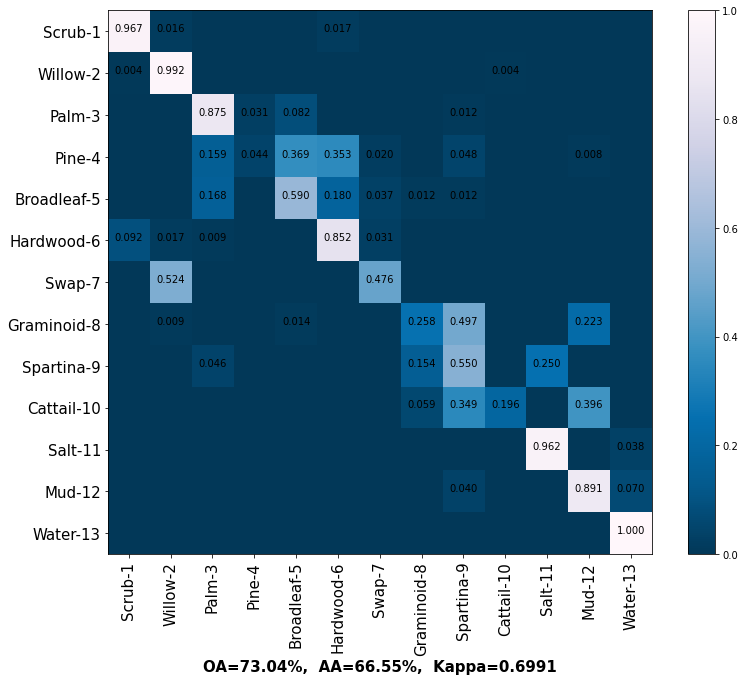

**************************************************
Final result:
OA: 72.97% | AA: 66.41% | Kappa: 0.70
[0.96710526 0.99173554 0.8745098  0.03984064 0.5875     0.85087719
 0.47115385 0.25581395 0.54913295 0.19354839 0.96172249 0.89043825
 1.        ]
**************************************************
Parameter:
dataset: KSC
flag_test: train
mode: CAF
gpu_id: 0
seed: 0
batch_size: 30
patch_size: 7
epoches: 200
learning_rate: 0.0005
gamma: 0.99
weight_decay: 0.001
train_number: 1
train_proportion: 0.1
**************************************************


In [11]:
model.eval()
tar_test, pre_test = test_epoch(model, test_loader)  # 收集所有真实标签和预测标签(np.array)
OA_test, AA_mean_test, Kappa_test, AA_test = output_metric(tar_test, pre_test)

# output classification maps
pre_u = valid_epoch(model, true_loader)
prediction_matrix = np.zeros((height, width), dtype=float)  # (512, 614)
for i in range(total_pos_true.shape[0]):
    prediction_matrix[total_pos_true[i, 0], total_pos_true[i, 1]] = pre_u[i] + 1
cm = confusion_matrix(y_true, pre_u)
plot_confusion_matrix(args.dataset, cm, path='./Confusion_Map_CapsCAF.pdf')


print("**************************************************")
print("Final result:")
print("OA: {:.2f}% | AA: {:.2f}% | Kappa: {:.2f}".format(OA_test * 100., AA_mean_test*100., Kappa_test))
print(AA_test)
print("**************************************************")
print("Parameter:")
print_args(vars(args))
print("**************************************************")

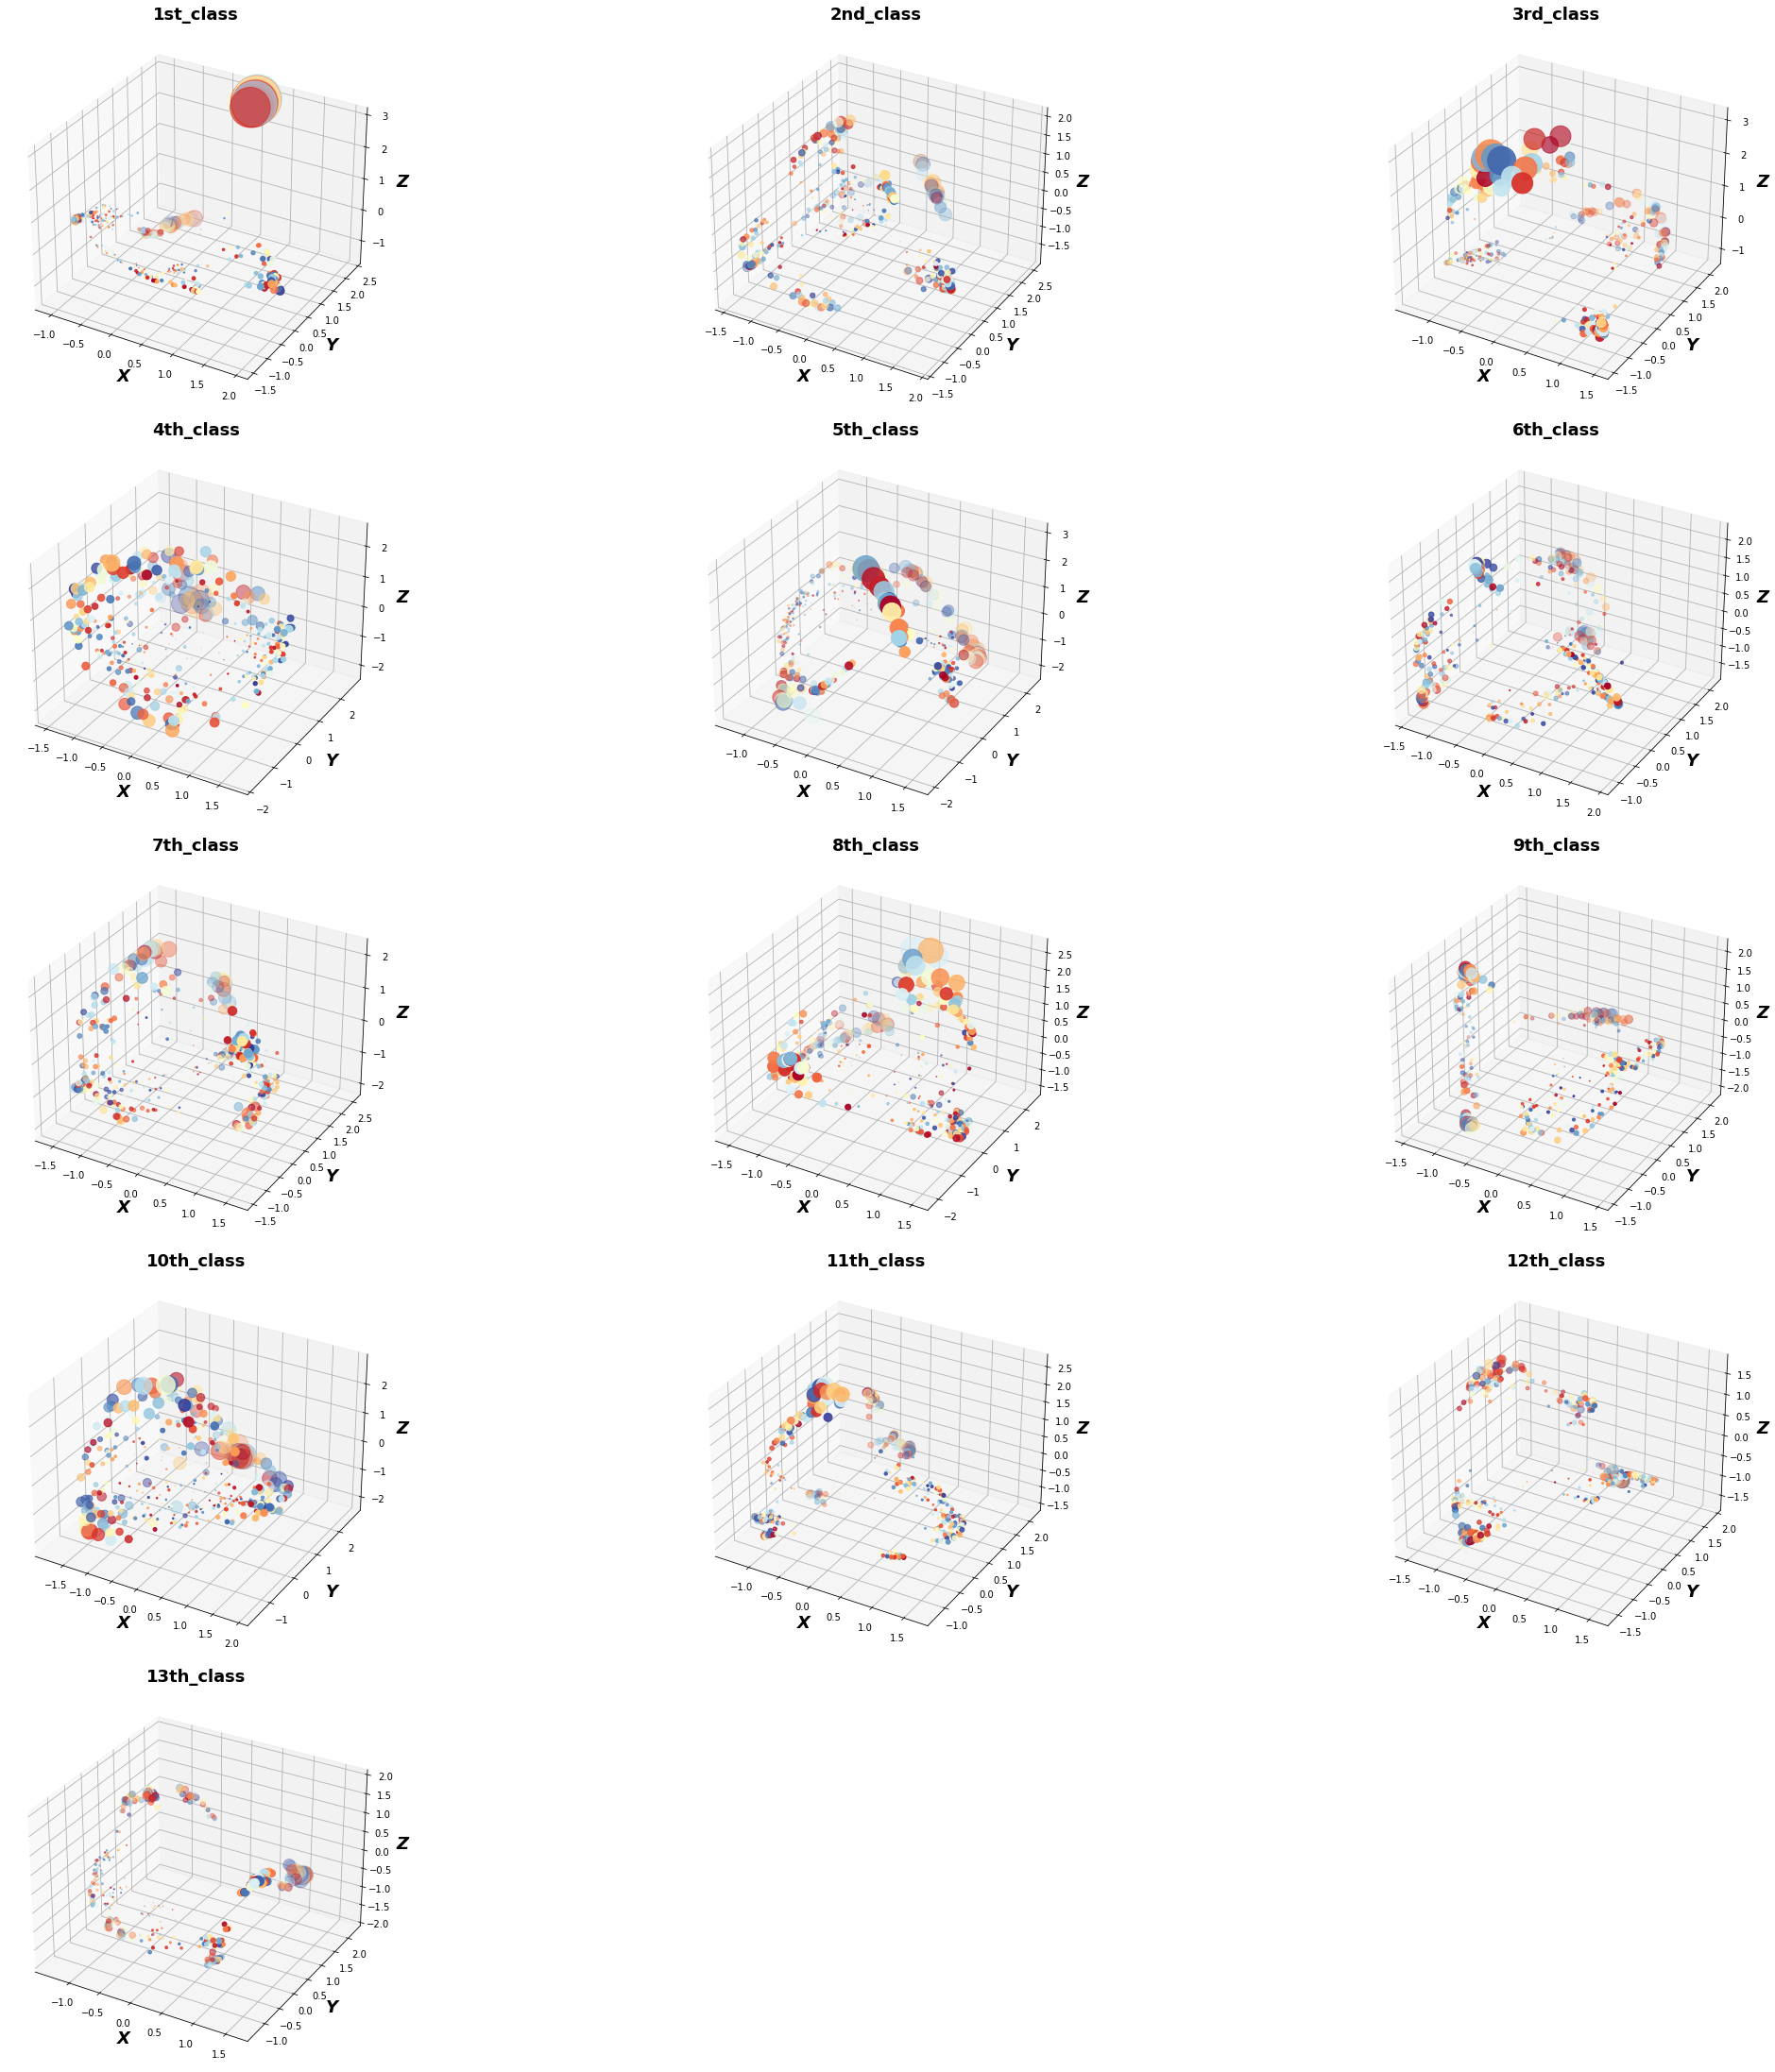

In [12]:
primary_caps_out = ActivationOutputData(model.primary_caps)  # (1, 400, 8)
# 传入测试样本
output, _ = model(x_train.cuda())
primary_caps_out.remove()

font_style = dict(family='DejaVu Sans', style='italic', size=18, weight='black')
title_style = dict(family='DejaVu Sans', size=18, weight='black')
fig = plt.figure(figsize=(30, 30))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.1, wspace=0.)
pca = PCA(n_components=3, whiten=True)
for i in range(num_classes):
    outputs = pca.fit_transform(primary_caps_out.outputs[i].detach().numpy())
    ax = fig.add_subplot(5, 3, i+1, projection='3d')
    x = outputs[:, 0]
    y = outputs[:, 1]
    z = outputs[:, 2]
    ax.scatter(x, y, z, s=np.power(np.sqrt(x**2+y**2+z**2), 6), c=np.random.rand(400), cmap=mpl.cm.RdYlBu)
    ax.set_xlabel('X', **font_style)
    ax.set_ylabel('Y', **font_style)
    ax.set_zlabel('Z', **font_style)
    if i == 0:
        plt.title('{}st_class'.format(i+1), **title_style)
    elif i == 1:
        plt.title('{}nd_class'.format(i+1), **title_style)
    elif i == 2:
        plt.title('{}rd_class'.format(i+1), **title_style)
    else:
        plt.title('{}th_class'.format(i+1), **title_style)
        
plt.show()        
fig.savefig('./Caps1_Outputs/primary_caps_outputs.pdf', bbox_inches='tight')

/tmp/ipykernel_408/871900638.py:7: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')  # 三维坐标轴


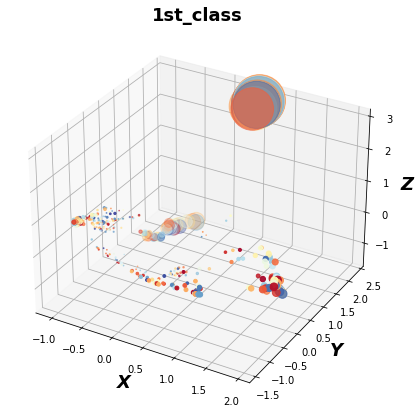

/tmp/ipykernel_408/871900638.py:7: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')  # 三维坐标轴


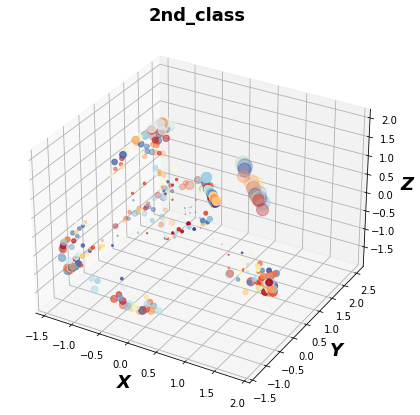

/tmp/ipykernel_408/871900638.py:7: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')  # 三维坐标轴


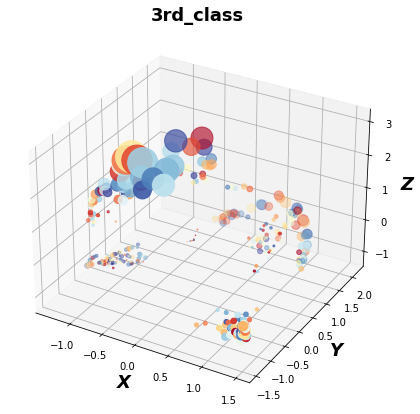

/tmp/ipykernel_408/871900638.py:7: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')  # 三维坐标轴


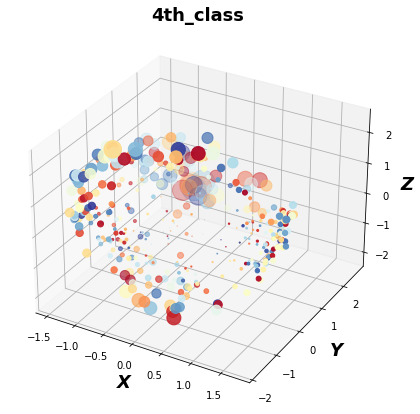

/tmp/ipykernel_408/871900638.py:7: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')  # 三维坐标轴


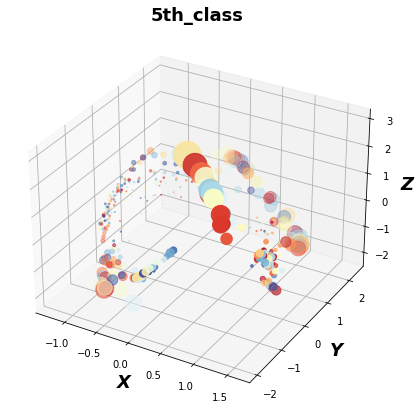

/tmp/ipykernel_408/871900638.py:7: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')  # 三维坐标轴


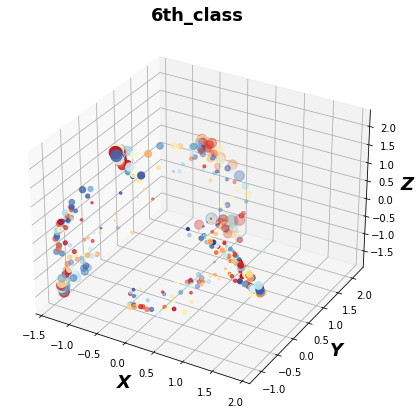

/tmp/ipykernel_408/871900638.py:7: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')  # 三维坐标轴


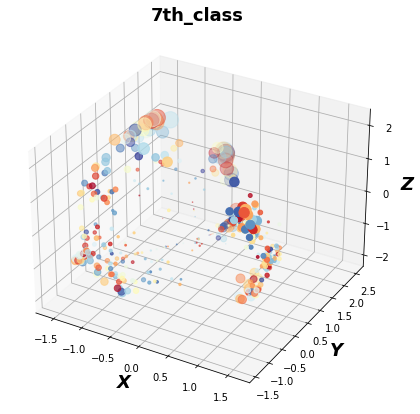

/tmp/ipykernel_408/871900638.py:7: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')  # 三维坐标轴


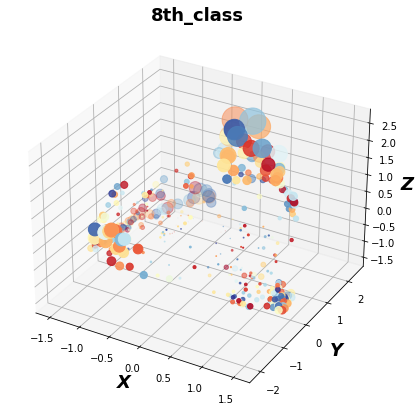

/tmp/ipykernel_408/871900638.py:7: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')  # 三维坐标轴


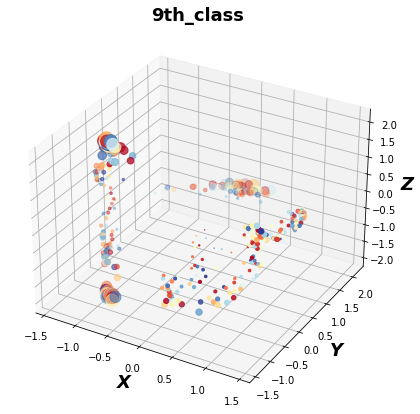

/tmp/ipykernel_408/871900638.py:7: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')  # 三维坐标轴


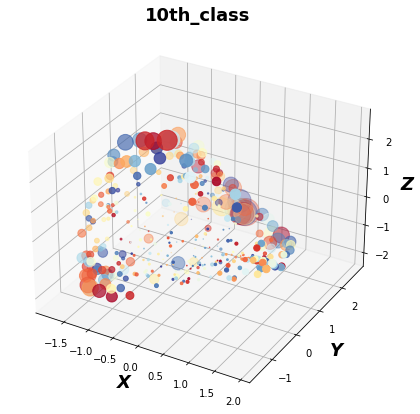

/tmp/ipykernel_408/871900638.py:7: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')  # 三维坐标轴


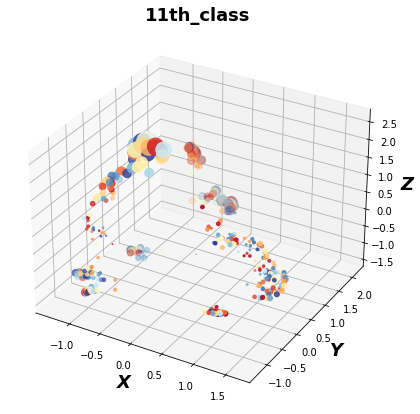

/tmp/ipykernel_408/871900638.py:7: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')  # 三维坐标轴


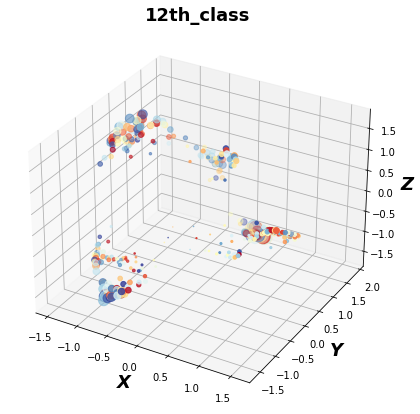

/tmp/ipykernel_408/871900638.py:7: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')  # 三维坐标轴


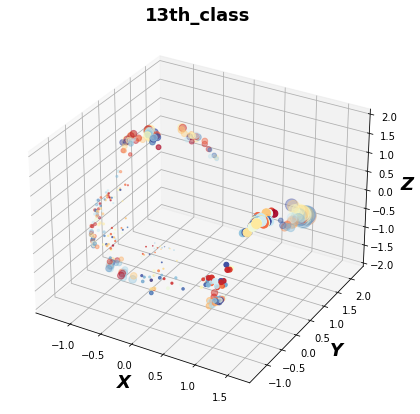

In [13]:
pca = PCA(n_components=3, whiten=True)
font_style = dict(family='DejaVu Sans', style='italic', size=18, weight='black')
title_style = dict(family='DejaVu Sans', size=18, weight='black')
for i in range(num_classes):
    outputs = pca.fit_transform(primary_caps_out.outputs[i].detach().numpy()) # (400, 3)
    fig = plt.figure(figsize=(7, 7))
    ax = fig.gca(projection='3d')  # 三维坐标轴
    x = outputs[:, 0]
    y = outputs[:, 1]
    z = outputs[:, 2]
    ax.scatter(x, y, z, s=np.power(np.sqrt(x**2+y**2+z**2), 6), c=np.random.rand(400), cmap=mpl.cm.RdYlBu)
    ax.set_xlabel('X', **font_style)
    ax.set_ylabel('Y', **font_style)
    ax.set_zlabel('Z', **font_style)
    if i == 0:
        plt.title('{}st_class'.format(i+1), **title_style)
    elif i == 1:
        plt.title('{}nd_class'.format(i+1), **title_style)
    elif i == 2:
        plt.title('{}rd_class'.format(i+1), **title_style)
    else:
        plt.title('{}th_class'.format(i+1), **title_style)
    plt.show()
    fig.savefig('./Caps1_Outputs/cap_class{}.pdf'.format(i+1), bbox_inches='tight')

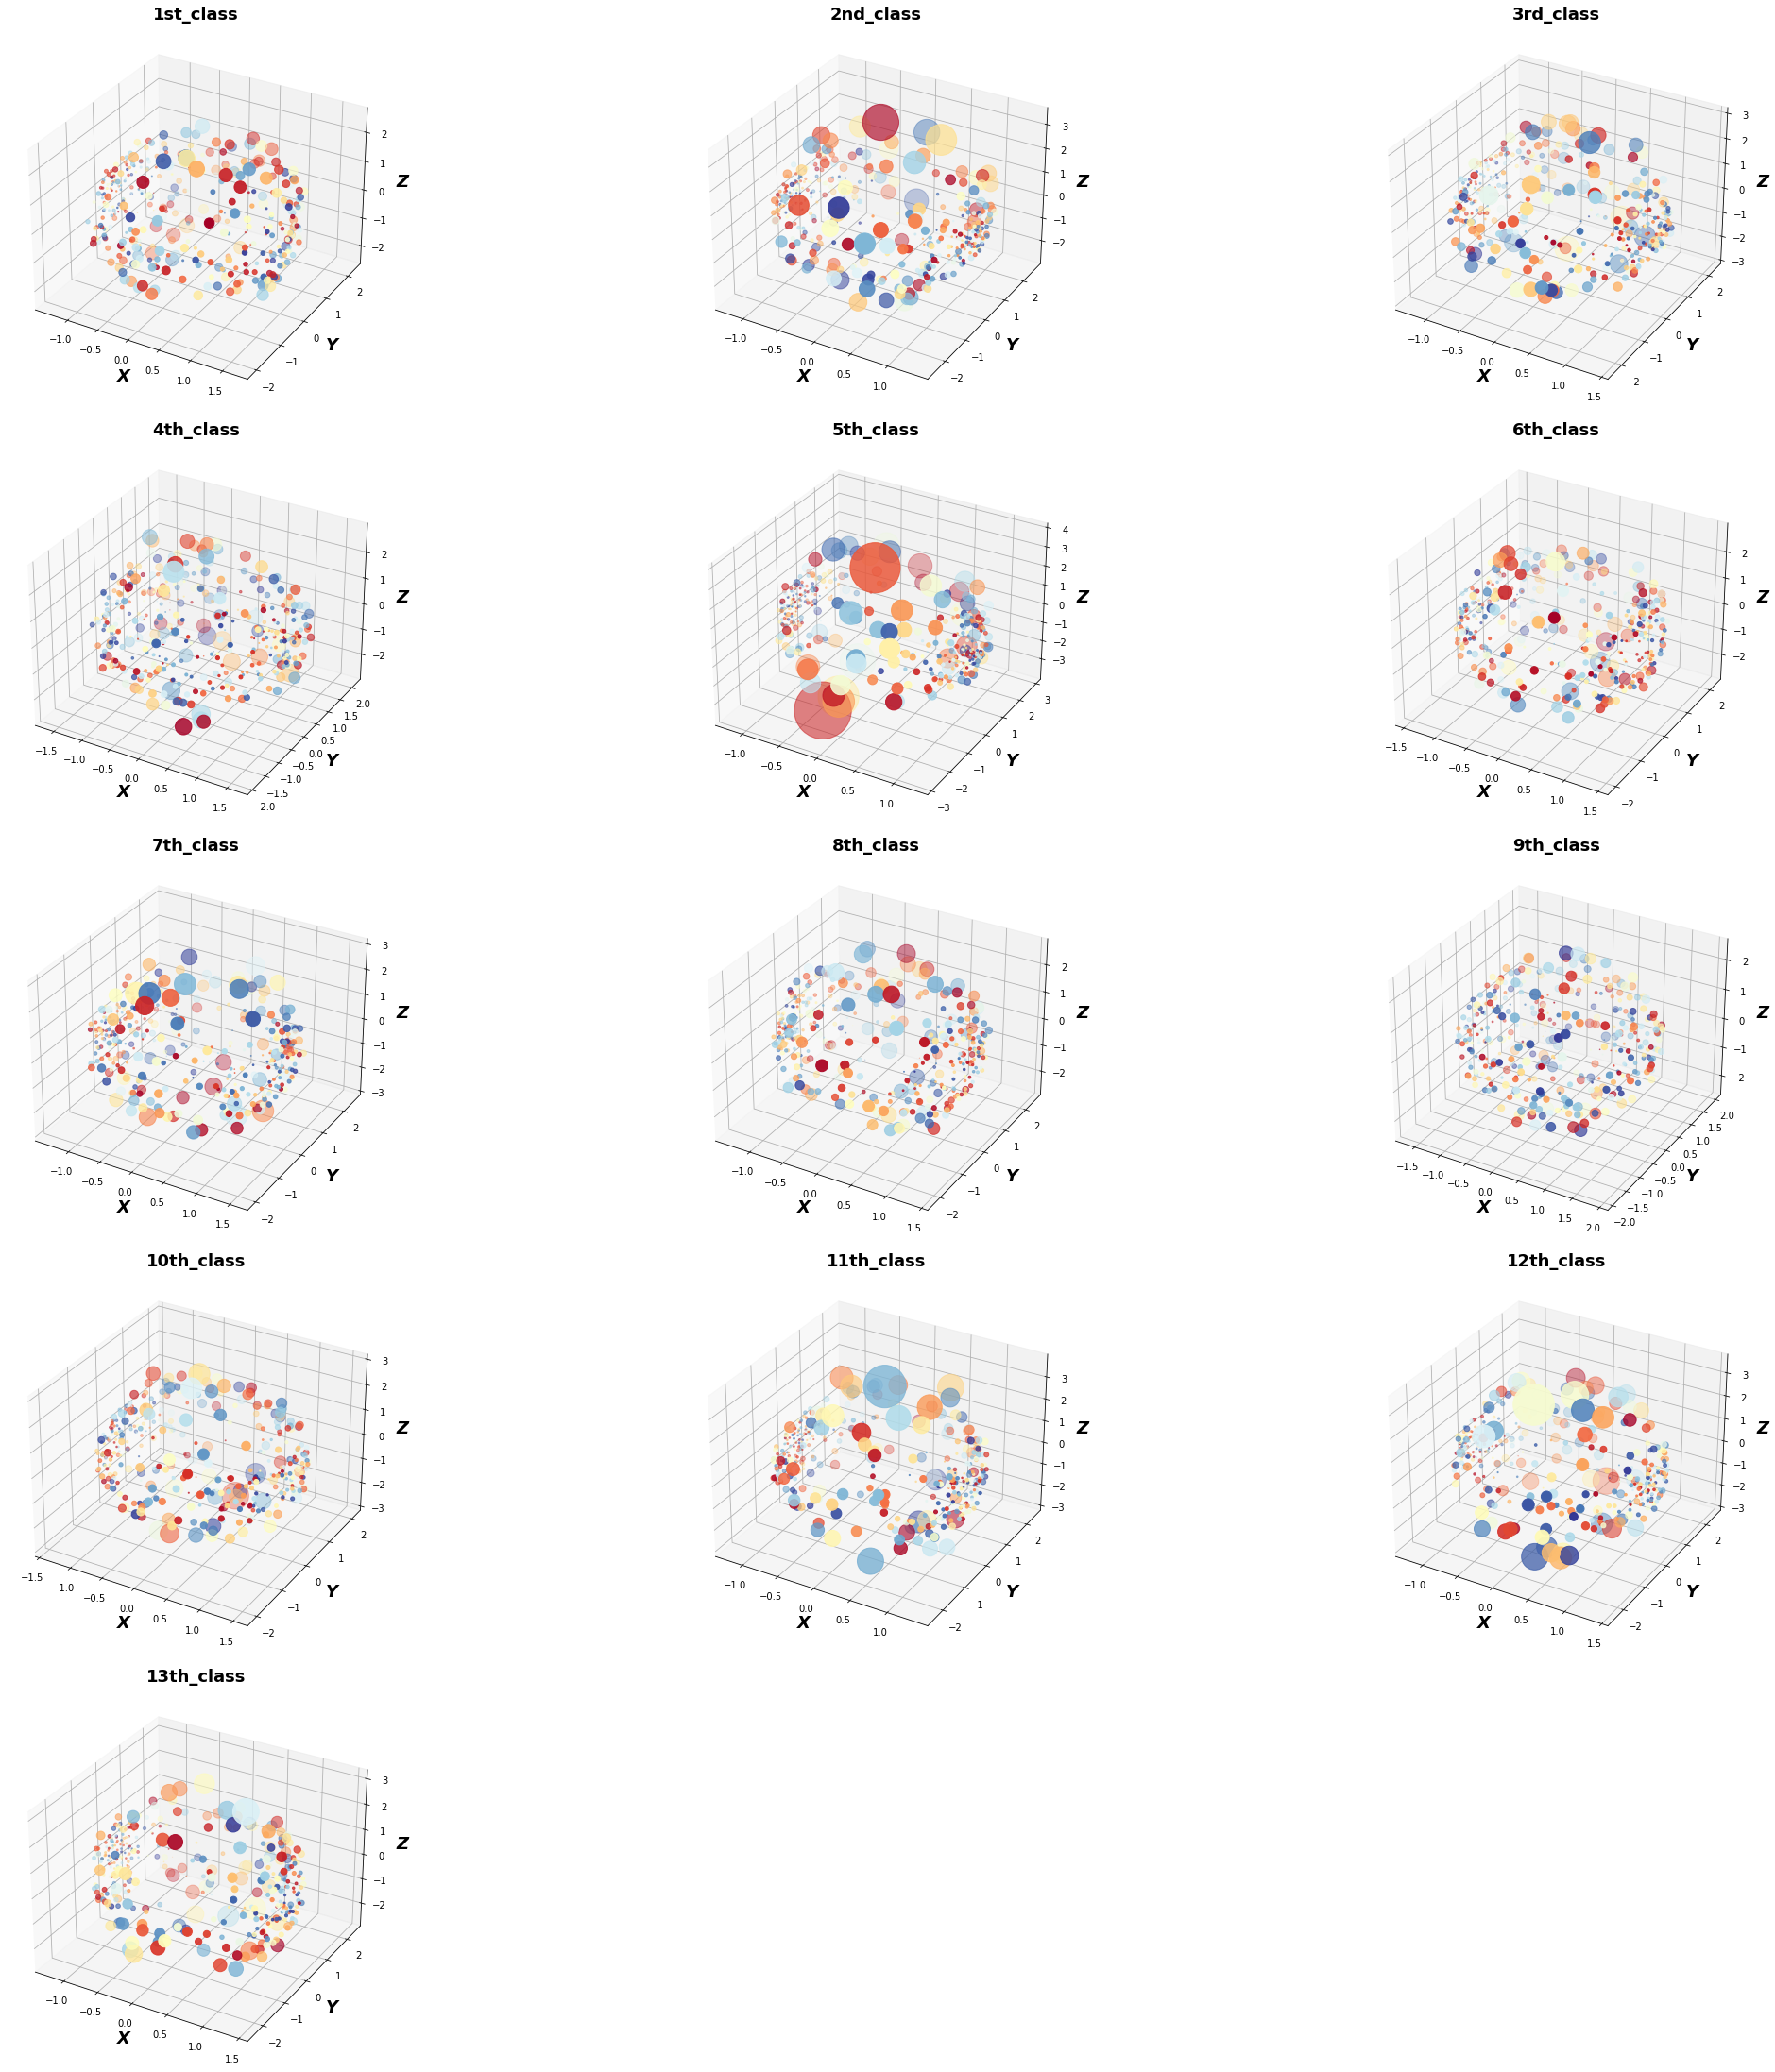

In [14]:
vit_out = ActivationOutputData(model.vit)  # (1, 400, 8)
# 传入测试样本
output, _ = model(x_train.cuda())
vit_out.remove()

font_style = dict(family='DejaVu Sans', style='italic', size=18, weight='black')
title_style = dict(family='DejaVu Sans', size=18, weight='black')
fig = plt.figure(figsize=(30, 30))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.1, wspace=0.)
pca = PCA(n_components=3, whiten=True)
for i in range(num_classes):
    outputs = pca.fit_transform(vit_out.outputs[i].detach().numpy())
    ax = fig.add_subplot(5, 3, i+1, projection='3d')
    x = outputs[:, 0]
    y = outputs[:, 1]
    z = outputs[:, 2]
    ax.scatter(x, y, z, s=np.power(np.sqrt(x**2+y**2+z**2), 6), c=np.random.rand(400), cmap=mpl.cm.RdYlBu)
    ax.set_xlabel('X', **font_style)
    ax.set_ylabel('Y', **font_style)
    ax.set_zlabel('Z', **font_style)
    if i == 0:
        plt.title('{}st_class'.format(i+1), **title_style)
    elif i == 1:
        plt.title('{}nd_class'.format(i+1), **title_style)
    elif i == 2:
        plt.title('{}rd_class'.format(i+1), **title_style)
    else:
        plt.title('{}th_class'.format(i+1), **title_style)
        
plt.show()        
fig.savefig('./ViT_Outputs/vit_outputs.pdf', bbox_inches='tight')

/tmp/ipykernel_408/335433074.py:7: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')  # 三维坐标轴


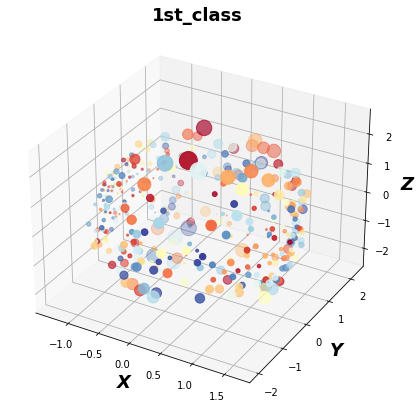

/tmp/ipykernel_408/335433074.py:7: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')  # 三维坐标轴


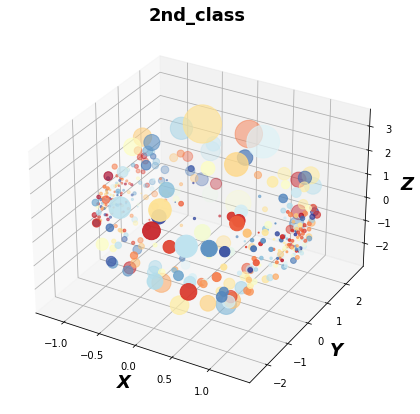

/tmp/ipykernel_408/335433074.py:7: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')  # 三维坐标轴


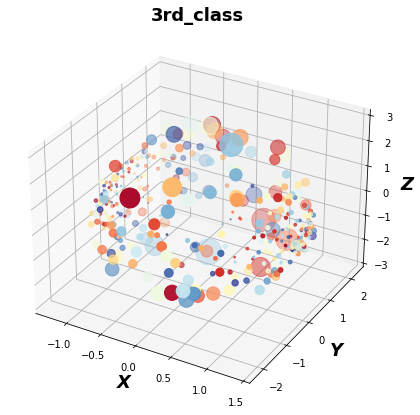

/tmp/ipykernel_408/335433074.py:7: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')  # 三维坐标轴


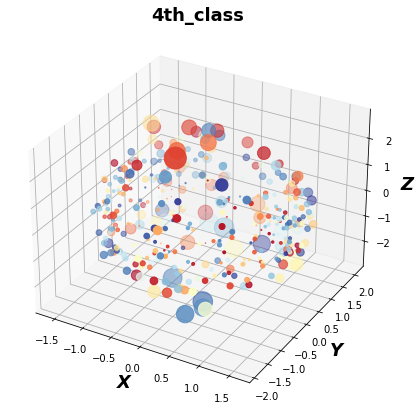

/tmp/ipykernel_408/335433074.py:7: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')  # 三维坐标轴


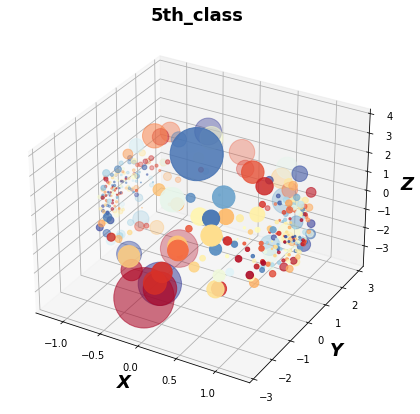

/tmp/ipykernel_408/335433074.py:7: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')  # 三维坐标轴


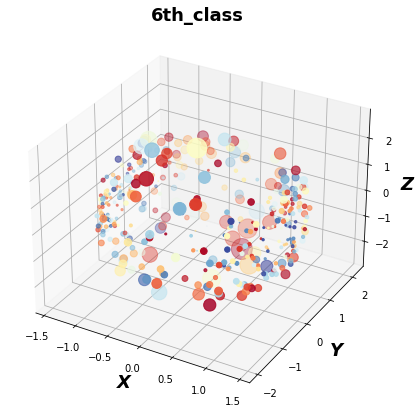

/tmp/ipykernel_408/335433074.py:7: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')  # 三维坐标轴


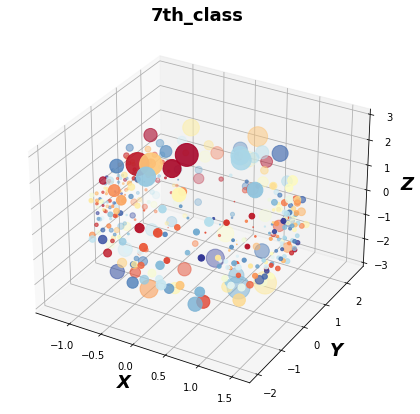

/tmp/ipykernel_408/335433074.py:7: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')  # 三维坐标轴


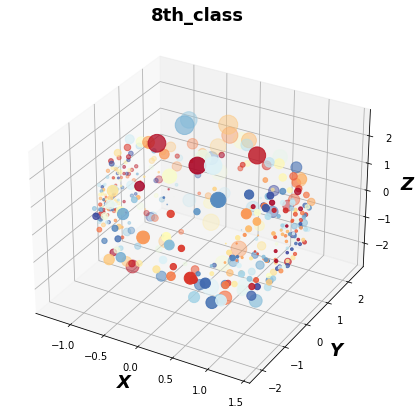

/tmp/ipykernel_408/335433074.py:7: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')  # 三维坐标轴


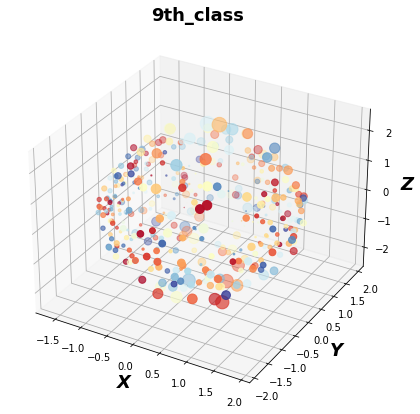

/tmp/ipykernel_408/335433074.py:7: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')  # 三维坐标轴


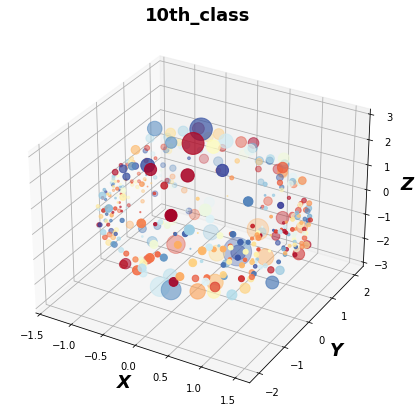

/tmp/ipykernel_408/335433074.py:7: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')  # 三维坐标轴


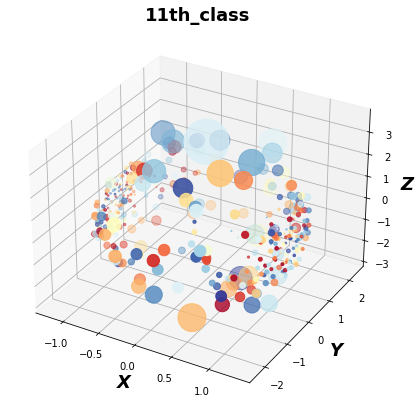

/tmp/ipykernel_408/335433074.py:7: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')  # 三维坐标轴


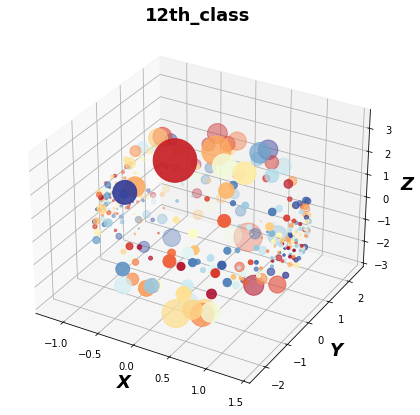

/tmp/ipykernel_408/335433074.py:7: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')  # 三维坐标轴


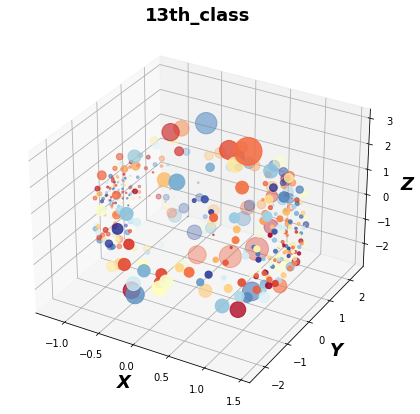

In [15]:
pca = PCA(n_components=3, whiten=True)
font_style = dict(family='DejaVu Sans', style='italic', size=18, weight='black')
title_style = dict(family='DejaVu Sans', size=18, weight='black')
for i in range(num_classes):
    outputs = pca.fit_transform(vit_out.outputs[i].detach().numpy()) # (400, 3)
    fig = plt.figure(figsize=(7, 7))
    ax = fig.gca(projection='3d')  # 三维坐标轴
    x = outputs[:, 0]
    y = outputs[:, 1]
    z = outputs[:, 2]
    ax.scatter(x, y, z, s=np.power(np.sqrt(x**2+y**2+z**2), 6), c=np.random.rand(400), cmap=mpl.cm.RdYlBu)
    ax.set_xlabel('X', **font_style)
    ax.set_ylabel('Y', **font_style)
    ax.set_zlabel('Z', **font_style)
    if i == 0:
        plt.title('{}st_class'.format(i+1), **title_style)
    elif i == 1:
        plt.title('{}nd_class'.format(i+1), **title_style)
    elif i == 2:
        plt.title('{}rd_class'.format(i+1), **title_style)
    else:
        plt.title('{}th_class'.format(i+1), **title_style)
    plt.show()
    fig.savefig('./ViT_Outputs/vit_class{}.pdf'.format(i+1), bbox_inches='tight')

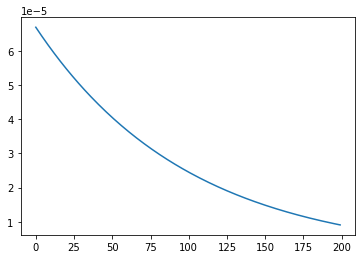

In [16]:
x = np.arange(200)
y = np.array([])
plt.figure()
for epoch in range(200):
    optimizer.step()
    y = np.append(y, scheduler.get_last_lr()[0])
    scheduler.step()

plt.plot(x, y)
plt.show()